# Title

description

* link to [video](https://www.youtube.com/watch?v=dLCGAuiJ1U0) for assignment overview
* analysis 1 con be done in conjustion with the What-if analysis with python module

## Preliminaries

In [1]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

## Create Model

First we will need to import the things we need from the whatif module

In [9]:
from whatif import Model
from whatif import get_sim_results_df

In [180]:
class SingleProductSPF(Model):
    """HW2 Model"""
    def __init__(self, fixed_cost=5000, var_cost=100, selling_price=115, 
                 spf_constant=4900, spf_linear=-35, spf_quadratic=0.06):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_constant = spf_constant
        self.spf_linear = spf_linear
        self.spf_quadratic = spf_quadratic

    def demand(self):
        """Computing Demand"""
        demand = self.spf_quadratic * self.selling_price**2 + self.spf_linear * self.selling_price + self.spf_constant
        return demand

    def production_cost(self):
        """Computing the cost to produce the product"""
        production_cost = (self.var_cost * self.demand()) + self.fixed_cost
        return production_cost

    
    def sales_revenue(self):
        """Compute sales revenue"""
        sales_revenue = self.selling_price * self.demand()
        return sales_revenue

    
    def profit(self):
        """Compute profit"""
        profit = self.sales_revenue() - self.production_cost()
        return profit




In [182]:
model = SingleProductSPF()
print(model)

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 115, 'spf_constant': 4900, 'spf_linear': -35, 'spf_quadratic': 0.06}


Checking to see if demand and profit are correct based on the info in the hw. 

In [185]:
print(model.demand())
print(model.profit())

1668.5
20027.5


Calculations and formulations were correct!

In [161]:
# Specifying input ranges
dt_param_range1 = {'selling_price': np.arange(80, 141, 10)}

# specifying output
outputs = ['profit', 'demand']

In [163]:
# Creation of 1-way data table
model_dt1 = model.data_table(dt_param_range1, outputs)
model_dt1

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


C:\Users\22nic\AppData\Local\Temp\ipykernel_3408\1133413442.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(model_dt1['selling_price'], model_dt1['profit'], model_dt1['demand'],


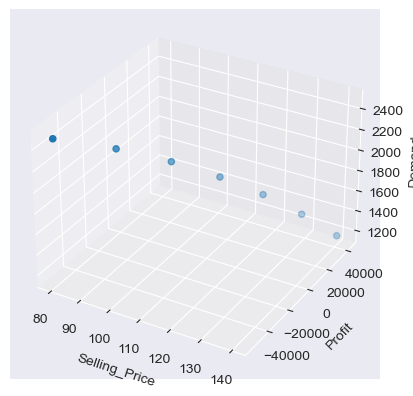

In [87]:
# Make the plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(model_dt1['selling_price'], model_dt1['profit'], model_dt1['demand'], 
                cmap=plt.cm.viridis)

ax.set_xlabel('Selling_Price')
ax.set_ylabel('Profit')
ax.set_zlabel('Demand')

plt.show();

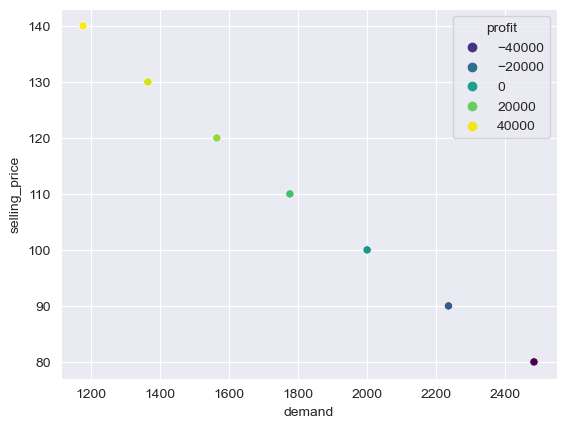

In [93]:
sns.set_style("darkgrid")
sns.scatterplot(x="demand", y="selling_price", hue="profit", data=model_dt1, palette="viridis");

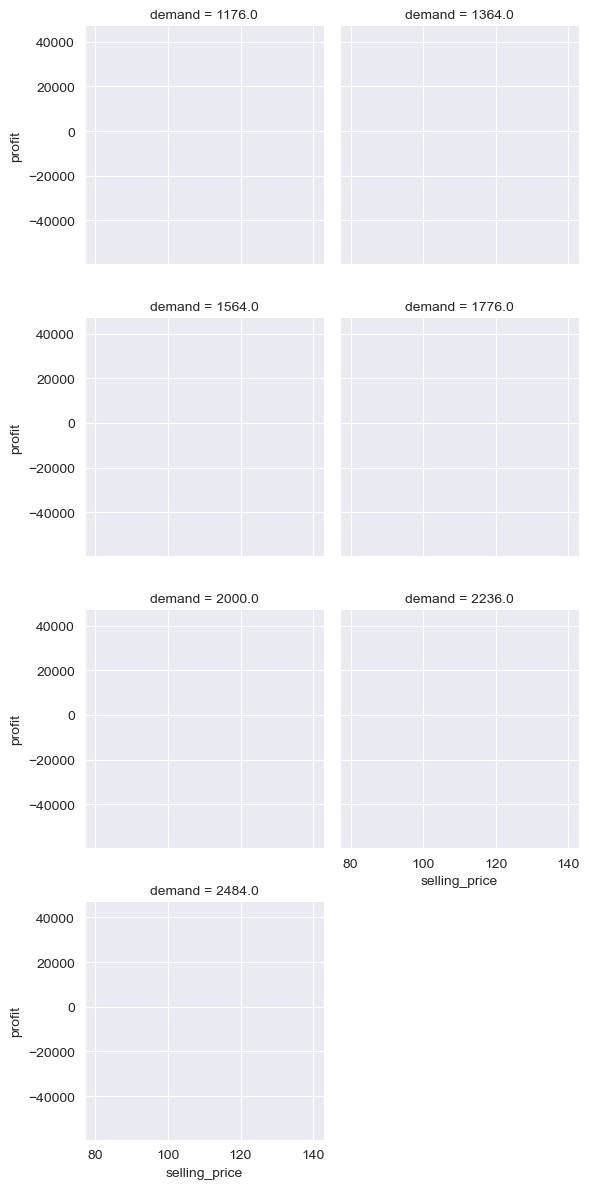

In [91]:
profit_dt_g = sns.FacetGrid(model_dt1, col="demand", sharey=True, col_wrap=2)
profit_dt_g = profit_dt_g.map(plt.plot, "selling_price", "profit")

**Explanation of graph:**

## Break Even

In [105]:
model_dt1

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


In [171]:
# Specifying input ranges
dt_param_range1 = {'selling_price': np.arange(80, 141, 10)}

# specifying output
outputs = ['profit', 'demand']

model_goal_dt1 = model.goal_seek('profit', 0, 'selling_price', 80, 140, 1000)
model_goal_dt1

102.57578606424767